In [1]:
import os
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

### Generate some toy values for "phi/psi" angles.
We will use the [von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution) (also called the "circular normal distribution") to generate some random 2d data to mimic phi and psi angles.

The toy dataset has two clusters:
- one centered around `phi = -2` and `psi = 3`. Because of the location of psi values, this cluster has psi values close to both 3 and -3, caused by periodicity.
- another centered around `phi = 1.5` and `psi = 0`. No significant periodicity issues points within this cluster.

In [3]:
# Create the raw dataset.
N = 1000
if N % 2 != 0:
    raise ValueError("Number of sample should be divisible by 2")

# Phi angles have two modes.
scale = 1/0.25
phi = np.concatenate([
    np.random.vonmises(-2, scale, (N//2, 1)),   # Samples centered around -2.
    np.random.vonmises(1.5, scale, (N//2, 1))   # Samples centered around 1.5.
    ], axis=0)

# Psi angles have two modes.
psi = np.concatenate([
    np.random.vonmises(3, scale, (N//2, 1)),  # Samples centered around 3.
    np.random.vonmises(0, scale, (N//2, 1))   # Samples centered around 0.
    ], axis=0)

# Classes.
classes = np.concatenate([
    np.zeros(N//2),  # First cluster.
    np.ones(N//2)    # Second cluster.
    ], axis=0)

# Raw dataset.
tors = np.concatenate([phi, psi], axis=1)

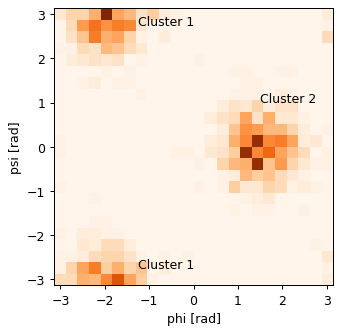

In [4]:
# Plot histogram.
fig, ax = plt.subplots(1, 1, dpi=90, figsize=(4, 4))
bins = np.linspace(-np.pi, np.pi, 25)
ax.hist2d(tors[:,0], tors[:,1], bins=[bins, bins], cmap="Oranges")
ax.set_xlabel("phi [rad]")
ax.set_ylabel("psi [rad]")
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.annotate("Cluster 1", (-1.25, 2.75))
ax.annotate("Cluster 1", (-1.25, -2.75))
ax.annotate("Cluster 2", (1.5, 1.0))
plt.show()

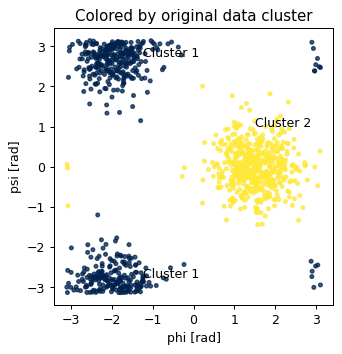

In [5]:
# Plot cluster classes.
fig, ax = plt.subplots(1, 1, dpi=90, figsize=(4, 4))
ax.set_title("Colored by original data cluster")
ax.scatter(tors[:,0], tors[:,1], alpha=0.75, c=classes,
           cmap="cividis", marker=".")
ax.annotate("Cluster 1", (-1.25, 2.75))
ax.annotate("Cluster 1", (-1.25, -2.75))
ax.annotate("Cluster 2", (1.5, 1.0))
ax.set_xlabel("phi [rad]")
ax.set_ylabel("psi [rad]")
plt.show()

### Cluster with t-SNE with raw values
We first fit our dataset with t-SNE, by using raw angle values.

In [6]:
tsne = TSNE(n_components=2,
            perplexity=100,
            early_exaggeration=10.0,
            learning_rate=100.0,
            n_iter=3500,
            metric="euclidean",  # NOTE: euclidean distance is used here.
            n_iter_without_progress=300,
            min_grad_norm=1e-7,
            init='random',
            method='barnes_hut',
            angle=0.5)
tsne_data = tsne.fit_transform(tors)

t-SNE identifies three clusters, since if you look at this dataset and consider Euclidean distances (distances in 2d space) it looks like there are three clusters. The cluster wrapped around the border in the original data (the blue one) is split into two different clusters.

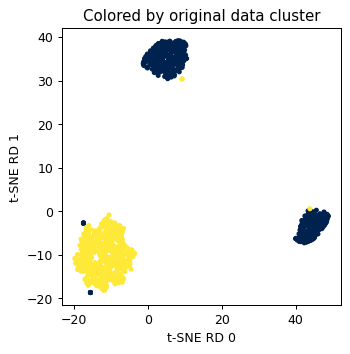

In [7]:
fig, ax = plt.subplots(1, 1, dpi=90, figsize=(4, 4))
ax.set_title("Colored by original data cluster")
ax.scatter(tsne_data[:,0], tsne_data[:,1],
           c=classes, cmap="cividis", marker=".")
ax.set_xlabel("t-SNE RD 0")
ax.set_ylabel("t-SNE RD 1")
plt.show()

### Using a different measurment of distance
t-SNE works by looking at some measurement of "distance" between datapoints. The sklearn implementation of t-SNE by default computes the Euclidean distance between datapoints. If we do this, our method will fail at clustering angular data close the "borders" of the plot. We will modify the way distances between datapoints are computed as follows:
- For each angle we compute its sine and cosine values.
- If plotted on a unit circle, sine and cosine values appear as the components of a unit vector,
pointing in a direction dependent on the angle.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Sinus_und_Kosinus_am_Einheitskreis_1.svg/1024px-Sinus_und_Kosinus_am_Einheitskreis_1.svg.png" width="250" />

- We represent each angular value as the corresponding unit vector.
- Finally, we calculate the distances between angles using the Euclidean distances between the **unit vectors**. This is because the unit vectors from angles with values close to -3 and 3 rads point in very similar directions. This is illustrated in the cell below.



angle 0 = -3.05 rad
angle 1 = 3.05 rad
Euclidean distance = 6.1
Sincos euclidean distance = 0.1829292844648744


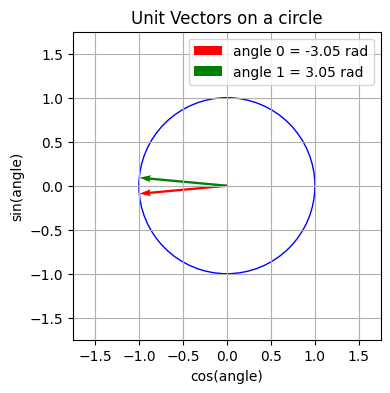

In [8]:
a0 = -3.05
a1 = 3.05

print("angle 0 = {} rad".format(a0))
print("angle 1 = {} rad".format(a1))

raw_euclidean_dist = np.sqrt(np.square(a0 - a1).sum())
print("Euclidean distance =", raw_euclidean_dist)

v0 = np.array([np.cos(a0), np.sin(a0)])
v1 = np.array([np.cos(a1), np.sin(a1)])
sincos_euclidean_distance = np.sqrt(np.square(v0-v1).sum())
print("Sincos euclidean distance =", sincos_euclidean_distance)

# Create a unit circle.
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
# Create the plot.
fig, ax = plt.subplots(figsize=(4, 4))
# Add the circle to the plot.
ax.add_artist(circle)
# Plot the vectors.
ax.quiver(0, 0, v0[0], v0[1], angles='xy', scale_units='xy',
          scale=1, color='red', label="angle 0 = {} rad".format(a0))
ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy',
          scale=1, color='green', label="angle 1 = {} rad".format(a1))
# Configure the plot.
ax.set_aspect('equal')
limit = 1.75
plt.xlim(-limit, limit)
plt.ylim(-limit, limit)
plt.grid(True)
plt.xlabel('cos(angle)')
plt.ylabel('sin(angle)')
plt.title('Unit Vectors on a circle')
plt.legend(loc="upper right")
# Display the plot.
plt.show()

### Cluster with t-SNE by using distances between cos/sin vectors

We define some functions to convert angles (expressed in radians) to cos/sin values and to compute distances between unit vectors of cos/sin coordinates.

In [9]:
def unit_vectorize(a):
    """Convert an array with (*, N) angles in an array with (*, N, 2) sine and
    cosine values for the N angles."""
    v = np.concatenate([np.cos(a)[...,None], np.sin(a)[...,None]], axis=-1)
    return v

def unit_vector_distance(a0, a1):
    """Compute the sum of distances between two (*, N, 2) arrays storing the
    sine and cosine values of N angles."""
    v0 = unit_vectorize(a0)
    v1 = unit_vectorize(a1)
    # Distance between every pair of N angles.
    dist = np.sqrt(np.square(v0 - v1).sum(axis=-1))
    # We sum over the N angles.
    dist = dist.sum(axis=-1)
    return dist

Quick sanity check.

In [10]:
# Test the distance function.
def get_small_noise():
    return np.random.randn()*0.01

# Example of a pair of phi/psi angles values coming from Cluster 1.
clst1_0 = [-2+get_small_noise(), 3+get_small_noise()] 
clst1_1 = [-2+get_small_noise(), 3+get_small_noise()]

# Example of a pair of phi/psi angles values coming from Cluster 2.
clst2_0 = [1.5+get_small_noise(), 0+get_small_noise()]

# Distance between cluster 1 datapoints should be small.
print("Unit vector distance between Cluster 1 - Cluster 1 datapoints:",
      unit_vector_distance(clst1_0, clst1_1))
# Distance between cluster 1 and cluster 2 datapoints should be larger.
print("Unit vector distance between Cluster 1 - Cluster 2 datapoints:",
      unit_vector_distance(clst1_0, clst2_0))

Unit vector distance between Cluster 1 - Cluster 1 datapoints: 0.030283206802933955
Unit vector distance between Cluster 1 - Cluster 2 datapoints: 3.9594037289958406


Fit t-SNE with the modified distance metric.

In [11]:
tsne = TSNE(n_components=2,
            perplexity=100,
            early_exaggeration=10.0,
            learning_rate=100.0,
            n_iter=3500,
            metric=unit_vector_distance,  # NOTE: we have only changed the function to compute distances.
            n_iter_without_progress=300,
            min_grad_norm=1e-7,
            init='random',
            method='barnes_hut',
            angle=0.5)
tsne_data = tsne.fit_transform(tors)

Using the distance measurment which takes into account periodicity, t-SNE is able to separate the two clusters. NOTE: is using a large scale value for the von Mises distribution, some datapoints will be assigned to the wrong cluster anyway.

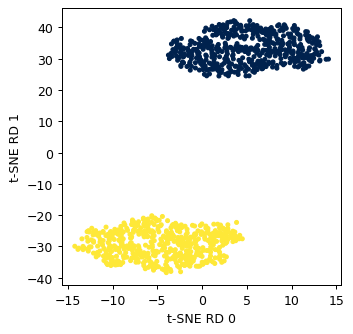

In [12]:
fig, ax = plt.subplots(1, 1, dpi=90, figsize=(4, 4))
ax.scatter(tsne_data[:,0], tsne_data[:,1],
           c=classes, cmap="cividis", marker=".")
ax.set_xlabel("t-SNE RD 0")
ax.set_ylabel("t-SNE RD 1")
plt.show()